# The Context Manager aka the Measurement Object

This notebook shows some ways of performing different measurements using 
QCoDeS parameters and the new DataSet accessed via a context manager.


In [1]:
%matplotlib inline
from collections import OrderedDict
from typing import Dict, Callable
from inspect import signature
import numpy.random as rd
import matplotlib.pyplot as plt
import json
from functools import partial
import numpy as np

from time import sleep, monotonic

import qcodes as qc
from qcodes import Station
from qcodes.dataset.experiment_container import Experiment, load_last_experiment
from qcodes.tests.instrument_mocks import DummyInstrument
from qcodes.dataset.param_spec import ParamSpec
from qcodes.dataset.measurements import Measurement
from qcodes.dataset.plotting import plot_by_id
from qcodes.dataset.data_export import get_shaped_data_by_runid

# import logging
# logging.basicConfig(level=logging.DEBUG, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')


/Users/jhn/.pyenv/versions/3.6.4/envs/qcodes-3.6.4/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# a generator to simulate a physical signal, in this case an exponentially
# decaying signal

def exponential_decay(a: float, b: float):
    """
    Yields a*exp(-b*x) where x is put in 
    """
    x = 0
    while True:
        x = yield
        yield a*np.exp(-b*x) + 0.02*a*np.random.randn()

In [3]:
# preparatory mocking of physical setup

dac = DummyInstrument('dac', gates=['ch1', 'ch2'])
dmm = DummyInstrument('dmm', gates=['v1', 'v2'])

station = qc.Station(dmm, dac)

In [4]:
# and then a bit of "wiring" to make the dmm "measure"
# the exponential decay

ed = exponential_decay(5, 0.2)
next(ed)

def customgetter(dac):
    val = ed.send(dac.ch1())
    next(ed)
    return val
    
dmm.v1.get = partial(customgetter, dac)

In [5]:
# now make some silly set-up and tear-down actions

def veryfirst():
    print('Starting the measurement')

def numbertwo(inst1, inst2):
    print('Doing stuff with the following two instruments: {}, {}'.format(inst1, inst2))
    
def thelast():
    print('End of experiment')

In [6]:
# And then run an experiment

meas = Measurement()
meas.register_parameter(dac.ch1)  # register the first independent parameter
meas.register_parameter(dmm.v1, setpoints=(dac.ch1,))  # now register the dependent oone
meas.add_before_run(veryfirst, ())  # add a set-up action
meas.add_before_run(numbertwo, (dmm, dac))  # add another set-up action
meas.add_after_run(thelast, ())  # add a tear-down action

meas.write_period = 2


with meas.run() as datasaver:
             
    for set_v in np.linspace(0, 25, 10):
        dac.ch1.set(set_v)
        get_v = dmm.v1.get()
        datasaver.add_result((dac.ch1, set_v),
                             (dmm.v1, get_v))
    
    dataid = datasaver.run_id  # convenient to have for plotting


Starting the measurement
Doing stuff with the following two instruments: <DummyInstrument: dmm>, <DummyInstrument: dac>
Starting experimental run with id: 248
End of experiment


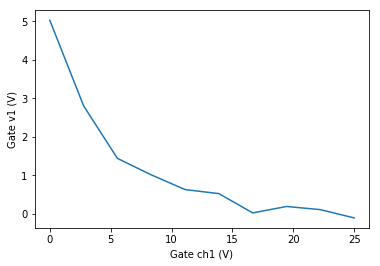

In [7]:
fig = plot_by_id(dataid)

In [8]:
get_shaped_data_by_runid(dataid)

[[{'data': array([ 0.        ,  2.77777778,  5.55555556,  8.33333333, 11.11111111,
          13.88888889, 16.66666667, 19.44444444, 22.22222222, 25.        ]),
   'label': 'Gate ch1',
   'name': 'dac_ch1',
   'unit': 'V'},
  {'data': array([ 5.02422732,  2.80022087,  1.43614856,  1.00804448,  0.62610421,
           0.52048833,  0.01962194,  0.18684074,  0.10511549, -0.11028619]),
   'label': 'Gate v1',
   'name': 'dmm_v1',
   'unit': 'V'}]]

## The power of the new construct

This new form is so free that we may easily do thing impossible with the old Loop construct

In [9]:
# from the above plot, we decide that a voltage below 
# 1 V is uninteresting, so we stop the sweep at that point
# thus, we do not know in advance how many points we'll measure

with meas.run() as datasaver:
        
    for set_v in np.linspace(0, 25, 100):
        dac.ch1.set(set_v)
        get_v = dmm.v1.get()        
        datasaver.add_result((dac.ch1, set_v),
                             (dmm.v1, get_v))

        if get_v < 1:
            break
        
    
    dataid = datasaver.run_id  # convenient to have for plotting

Starting the measurement
Doing stuff with the following two instruments: <DummyInstrument: dmm>, <DummyInstrument: dac>
Starting experimental run with id: 249
End of experiment


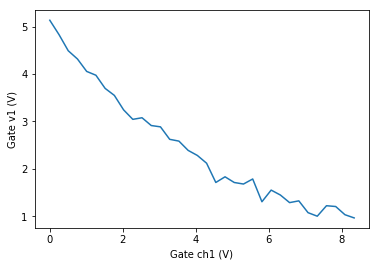

In [10]:
fig = plot_by_id(dataid)

In [11]:
get_shaped_data_by_runid(dataid)

[[{'data': array([0.        , 0.25252525, 0.50505051, 0.75757576, 1.01010101,
          1.26262626, 1.51515152, 1.76767677, 2.02020202, 2.27272727,
          2.52525253, 2.77777778, 3.03030303, 3.28282828, 3.53535354,
          3.78787879, 4.04040404, 4.29292929, 4.54545455, 4.7979798 ,
          5.05050505, 5.3030303 , 5.55555556, 5.80808081, 6.06060606,
          6.31313131, 6.56565657, 6.81818182, 7.07070707, 7.32323232,
          7.57575758, 7.82828283, 8.08080808, 8.33333333]),
   'label': 'Gate ch1',
   'name': 'dac_ch1',
   'unit': 'V'},
  {'data': array([5.13492058, 4.83152868, 4.49126899, 4.31748528, 4.05524225,
          3.97496463, 3.69724074, 3.54941978, 3.24491761, 3.04427339,
          3.07796028, 2.91380552, 2.88593143, 2.62277698, 2.58512698,
          2.38938586, 2.28262353, 2.11894657, 1.71248735, 1.83194081,
          1.71209706, 1.67970934, 1.78628358, 1.30583181, 1.55185275,
          1.44784124, 1.28758522, 1.32473036, 1.07564871, 1.00117083,
          1.22211725,

In [12]:
# Or we might want to simply get as many points as possible in 10 s
# randomly sampling the region between 0 V and 10 V (for the setpoint axis)

from time import monotonic, sleep

with meas.run() as datasaver:
    
    t_start = monotonic()
    
    while monotonic() - t_start < 10:
        set_v = 10/2*(np.random.rand() + 1)
        dac.ch1.set(set_v)
        
        # some sleep to not get too many points (or to let the system settle)
        sleep(0.1)
        
        get_v = dmm.v1.get()        
        datasaver.add_result((dac.ch1, set_v),
                             (dmm.v1, get_v))
    
    dataid = datasaver.run_id  # convenient to have for plotting

Starting the measurement
Doing stuff with the following two instruments: <DummyInstrument: dmm>, <DummyInstrument: dac>
Starting experimental run with id: 250
End of experiment


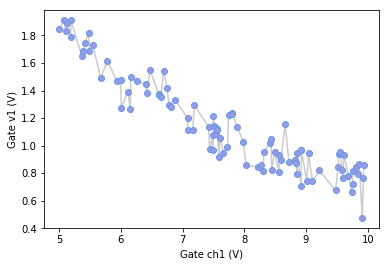

In [13]:
fig = plot_by_id(dataid)
# we slightly tweak the plot to better visualise the highly non-standard axis spacing
fig.axes[0].lines[0].set_marker('o')
fig.axes[0].lines[0].set_markerfacecolor((0.6, 0.6, 0.9))
fig.axes[0].lines[0].set_markeredgecolor((0.4, 0.6, 0.9))
fig.axes[0].lines[0].set_color((0.8, 0.8, 0.8))

In [14]:
get_shaped_data_by_runid(dataid)

[[{'data': array([9.92817048, 6.87862308, 7.19120548, 7.98320867, 5.47746266,
          8.26959968, 8.5619787 , 9.10362253, 8.84293848, 8.31916564,
          9.93526671, 6.42070143, 8.02725837, 5.00442506, 5.07894416,
          9.55543691, 7.08349654, 9.59105609, 5.54567438, 5.39436853,
          7.49309723, 9.47867337, 6.62005061, 5.10717325, 9.80522766,
          7.16287811, 6.15826623, 6.64709001, 5.18860527, 9.03981708,
          9.58247653, 9.68659024, 6.15362278, 9.61346192, 7.60387051,
          8.84911476, 9.51904172, 9.83711488, 6.69337192, 8.40994069,
          9.01113354, 7.49424951, 8.59135231, 9.75549979, 7.58440056,
          9.52642684, 8.29865676, 7.88851515, 8.44182402, 7.66220855,
          6.81966921, 7.49934869, 7.79579524, 8.43269376, 5.12722796,
          5.36854353, 8.92556007, 8.21610639, 7.53462338, 7.80573047,
          5.18843966, 8.49039613, 6.40015127, 7.74477735, 7.43897501,
          6.11243378, 9.91173655, 8.92273907, 5.49127886, 7.51055059,
          8.

## Some 2D examples

In [15]:
# For the 2D, we'll need a new batch of parameters, notably one with two 
# other parameters as setpoints. We therefore define a new Measurement
# with new parameters

meas = Measurement()
meas.register_parameter(dac.ch1)  # register the first independent parameter
meas.register_parameter(dac.ch2)  # register the second independent parameter
meas.register_parameter(dmm.v1, setpoints=(dac.ch1, dac.ch2))  # now register the dependent oone

In [16]:
# and we'll make a 2D gaussian to sample from/measure
def gauss_model(x0: float, y0: float, sigma: float, noise: float=0.0005):
    """
    Returns a generator sampling a gaussian. The gaussian is
    normalised such that its maximal value is simply 1
    """
    while True:
        (x, y) = yield
        model = np.exp(-((x0-x)**2+(y0-y)**2)/2/sigma**2)*np.exp(2*sigma**2)
        noise = np.random.randn()*noise
        yield model + noise

In [17]:
# and finally wire up the dmm v1 to "measure" the gaussian

gauss = gauss_model(0.1, 0.2, 0.25)
next(gauss)

def measure_gauss(dac):
    val = gauss.send((dac.ch1.get(), dac.ch2.get()))
    next(gauss)
    return val

dmm.v1.get = partial(measure_gauss, dac)

In [18]:
# run a 2D sweep

with meas.run() as datasaver:

    for v1 in np.linspace(-1, 1, 200):
        for v2 in np.linspace(-1, 1, 200):
            dac.ch1(v1)
            dac.ch2(v2)
            val = dmm.v1.get()
            datasaver.add_result((dac.ch1, v1),
                                 (dac.ch2, v2),
                                 (dmm.v1, val))
            
    dataid = datasaver.run_id

Starting experimental run with id: 251


CPU times: user 367 ms, sys: 19.7 ms, total: 386 ms
Wall time: 387 ms


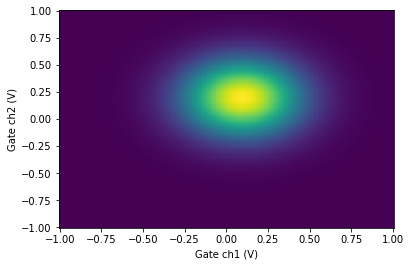

In [19]:
%%time
fig = plot_by_id(dataid)

In [20]:
get_shaped_data_by_runid(dataid)

[[{'data': array([-1.        , -0.98994975, -0.9798995 , -0.96984925, -0.95979899,
          -0.94974874, -0.93969849, -0.92964824, -0.91959799, -0.90954774,
          -0.89949749, -0.88944724, -0.87939698, -0.86934673, -0.85929648,
          -0.84924623, -0.83919598, -0.82914573, -0.81909548, -0.80904523,
          -0.79899497, -0.78894472, -0.77889447, -0.76884422, -0.75879397,
          -0.74874372, -0.73869347, -0.72864322, -0.71859296, -0.70854271,
          -0.69849246, -0.68844221, -0.67839196, -0.66834171, -0.65829146,
          -0.64824121, -0.63819095, -0.6281407 , -0.61809045, -0.6080402 ,
          -0.59798995, -0.5879397 , -0.57788945, -0.5678392 , -0.55778894,
          -0.54773869, -0.53768844, -0.52763819, -0.51758794, -0.50753769,
          -0.49748744, -0.48743719, -0.47738693, -0.46733668, -0.45728643,
          -0.44723618, -0.43718593, -0.42713568, -0.41708543, -0.40703518,
          -0.39698492, -0.38693467, -0.37688442, -0.36683417, -0.35678392,
          -0.3467

In [21]:
# Looking at the above picture, we may decide to sample more finely in the central
# region

with meas.run() as datasaver:

    v1points = np.concatenate((np.linspace(-1, -0.5, 5),
                               np.linspace(-0.51, 0.5, 200),
                               np.linspace(0.51, 1, 5)))
    v2points = np.concatenate((np.linspace(-1, -0.25, 5),
                               np.linspace(-0.26, 0.5, 200),
                               np.linspace(0.51, 1, 5)))
    
    for v1 in v1points:
        for v2 in v2points:
            dac.ch1(v1)
            dac.ch2(v2)
            val = dmm.v1.get()
            datasaver.add_result((dac.ch1, v1),
                                 (dac.ch2, v2),
                                 (dmm.v1, val))

    dataid = datasaver.run_id

Starting experimental run with id: 252


CPU times: user 386 ms, sys: 19.3 ms, total: 406 ms
Wall time: 405 ms


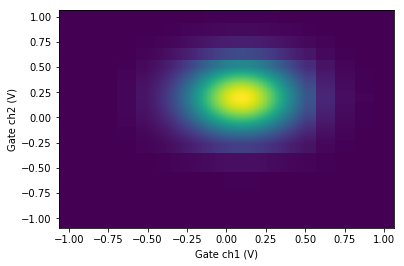

In [22]:
%%time
fig = plot_by_id(dataid)

In [23]:
get_shaped_data_by_runid(dataid)

[[{'data': array([-1.        , -0.875     , -0.75      , -0.625     , -0.51      ,
          -0.50492462, -0.5       , -0.49984925, -0.49477387, -0.48969849,
          -0.48462312, -0.47954774, -0.47447236, -0.46939698, -0.46432161,
          -0.45924623, -0.45417085, -0.44909548, -0.4440201 , -0.43894472,
          -0.43386935, -0.42879397, -0.42371859, -0.41864322, -0.41356784,
          -0.40849246, -0.40341709, -0.39834171, -0.39326633, -0.38819095,
          -0.38311558, -0.3780402 , -0.37296482, -0.36788945, -0.36281407,
          -0.35773869, -0.35266332, -0.34758794, -0.34251256, -0.33743719,
          -0.33236181, -0.32728643, -0.32221106, -0.31713568, -0.3120603 ,
          -0.30698492, -0.30190955, -0.29683417, -0.29175879, -0.28668342,
          -0.28160804, -0.27653266, -0.27145729, -0.26638191, -0.26130653,
          -0.25623116, -0.25115578, -0.2460804 , -0.24100503, -0.23592965,
          -0.23085427, -0.22577889, -0.22070352, -0.21562814, -0.21055276,
          -0.2054

In [24]:
# or even perform an adaptive sweep... ooohh...
#
# This example is a not-very-clever toy model example,
# but it nicely shows a semi-realistic measurement that the old qc.Loop
# could not handle

v1_points = np.linspace(-1, 1, 250)
v2_points = np.linspace(1, -1, 250)

threshold = 0.25

with meas.run() as datasaver:
    
    # Do normal sweeping until the peak is detected
    
    for v2ind, v2 in enumerate(v2_points):
        for v1ind, v1 in enumerate(v1_points):
            dac.ch1(v1)
            dac.ch2(v2)
            val = dmm.v1.get()
            datasaver.add_result((dac.ch1, v1),
                                 (dac.ch2, v2),
                                 (dmm.v1, val))
            if val > threshold:
                break
        else:
            continue
        break
        
    print(v1ind, v2ind, val)
    print('-'*10)
        
    # now be more clever, meandering back and forth over the peak
    doneyet = False
    rowdone = False
    v1_step = 1
    while not doneyet:
            v2 = v2_points[v2ind]
            v1 = v1_points[v1ind+v1_step-1]
            dac.ch1(v1)
            dac.ch2(v2)
            val = dmm.v1.get()
            datasaver.add_result((dac.ch1, v1),
                                 (dac.ch2, v2),
                                 (dmm.v1, val))
            if val < threshold:
                if rowdone:
                    doneyet = True
                v2ind += 1
                v1_step *= -1
                rowdone = True
            else:
                v1ind += v1_step
                rowdone = False
                
dataid = datasaver.run_id

Starting experimental run with id: 253
130 46 0.2508941683095357
----------


CPU times: user 351 ms, sys: 9.09 ms, total: 360 ms
Wall time: 359 ms


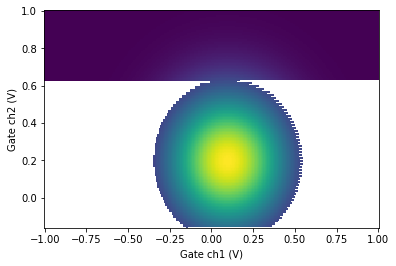

In [25]:
%%time
fig = plot_by_id(dataid)

In [26]:
get_shaped_data_by_runid(dataid)

[[{'data': array([-1.        , -0.99196787, -0.98393574, -0.97590361, -0.96787149,
          -0.95983936, -0.95180723, -0.9437751 , -0.93574297, -0.92771084,
          -0.91967871, -0.91164659, -0.90361446, -0.89558233, -0.8875502 ,
          -0.87951807, -0.87148594, -0.86345382, -0.85542169, -0.84738956,
          -0.83935743, -0.8313253 , -0.82329317, -0.81526104, -0.80722892,
          -0.79919679, -0.79116466, -0.78313253, -0.7751004 , -0.76706827,
          -0.75903614, -0.75100402, -0.74297189, -0.73493976, -0.72690763,
          -0.7188755 , -0.71084337, -0.70281124, -0.69477912, -0.68674699,
          -0.67871486, -0.67068273, -0.6626506 , -0.65461847, -0.64658635,
          -0.63855422, -0.63052209, -0.62248996, -0.61445783, -0.6064257 ,
          -0.59839357, -0.59036145, -0.58232932, -0.57429719, -0.56626506,
          -0.55823293, -0.5502008 , -0.54216867, -0.53413655, -0.52610442,
          -0.51807229, -0.51004016, -0.50200803, -0.4939759 , -0.48594378,
          -0.4779

## Random sampling 

We may also chose to sample completly randomly across the phase space

In [21]:
gauss = gauss_model(0.1, 0.2, 0.25)
next(gauss)

def measure_gauss(x, y):
    val = gauss.send((x, y))
    next(gauss)
    return val



In [22]:
v1_points = np.linspace(-1, 1, 250)
v2_points = np.linspace(1, -1, 250)

threshold = 0.25

npoints = 5000

with meas.run() as datasaver:
    for i in range(npoints):
        x = 2*(np.random.rand()-.5)
        y = 2*(np.random.rand()-.5)
        z = measure_gauss(x,y)
        datasaver.add_result((dac.ch1, x),
                     (dac.ch2, y),
                     (dmm.v1, z))
dataid = datasaver.run_id

Starting experimental run with id: 245


2D data does not seem to be on a grid. Falling back to scatter plot


CPU times: user 82.6 ms, sys: 6.66 ms, total: 89.3 ms
Wall time: 85.3 ms


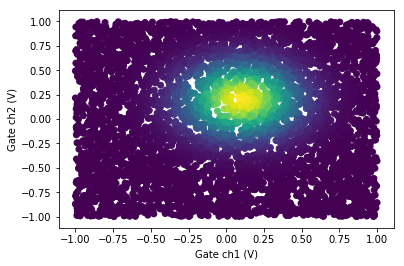

In [23]:
%%time
fig = plot_by_id(dataid)

## Optimiser

An example to show that the algorithm is flexible enough to be used with completly unstructured data such as the output of an downhill simplex optimization. The downhill simplex is somewhat more sensitive to noise and it is important that 'fatol' is set to match the expected noise.

In [24]:
from scipy.optimize import minimize

In [25]:
noise = 0.0005

gauss = gauss_model(0.1, 0.2, 0.25, noise=noise)
next(gauss)

def measure_gauss(x, y):
    val = gauss.send((x, y))
    next(gauss)
    return val


In [26]:
x0 = [np.random.rand(), np.random.rand()]
with meas.run() as datasaver:
    def mycallback(xk):
        datasaver.add_result((dac.ch1, xk[0]),
                     (dac.ch2, xk[1]),
                     (dmm.v1, measure_gauss(xk[0], xk[1])))
    
    res = minimize(lambda x: -measure_gauss(*x), x0, method='Nelder-Mead', tol=1e-10, 
                   callback=mycallback, options={'fatol': noise})
    
    run_id = datasaver.run_id

Starting experimental run with id: 246


In [27]:
res

 final_simplex: (array([[0.10000001, 0.2       ],
       [0.1       , 0.2       ],
       [0.10000001, 0.2       ]]), array([-1.13314845, -1.13314845, -1.13314845]))
           fun: -1.133148453066826
       message: 'Optimization terminated successfully.'
          nfev: 154
           nit: 73
        status: 0
       success: True
             x: array([0.10000001, 0.2       ])

2D data does not seem to be on a grid. Falling back to scatter plot


CPU times: user 53.2 ms, sys: 6.88 ms, total: 60.1 ms
Wall time: 57.2 ms


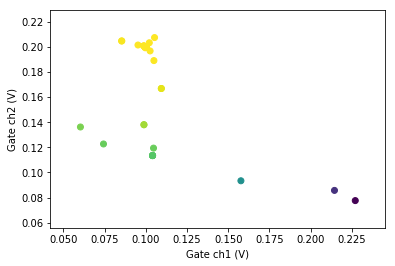

In [28]:
%%time
plot_by_id(run_id)

In [29]:
1

1